In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, date, timedelta
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Read csv into df and convert date to datetime
df = pd.read_csv("Aquifer_Petrignano.csv")
df["Date"] = pd.to_datetime(df["Date"], format = "%d/%m/%Y")

# Drop all data that doesn't have rainfall for Bastia Umbra
df = df[df.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)

# Drop one of the depths and temperatures.
df = df.drop(['Depth_to_Groundwater_P24', "Temperature_Petrignano"], axis = 1)

# Simplify column names
df.columns = ["Date", "Rainfall", "Depth_to_Groundwater", "Temperature", "Drainage_Volume", "River_Hydrometry"]

df.head()

,Date,Rainfall,Depth_to_Groundwater,Temperature,Drainage_Volume,River_Hydrometry
0,2009-01-01,0.0,-31.14,5.2,-24530.688,2.4
1,2009-01-02,0.0,-31.11,2.3,-28785.888,2.5
2,2009-01-03,0.0,-31.07,4.4,-25766.208,2.4
3,2009-01-04,0.0,-31.05,0.8,-27919.296,2.4
4,2009-01-05,0.0,-31.01,-1.9,-29854.656,2.3


In [4]:
# Set all zeros to NaN unless in Date or Rainfall column.
for feature in df.columns:
    if feature not in ["Date", "Rainfall"]:
        df[feature] = np.where(df[feature] == 0, np.nan, df[feature])
        
# Interpolate NaNs for selected columns
for feature in df.columns:
    if feature in ["Drainage_Volume", "River_Hydrometry", "Depth"]:
        df[feature] = df[feature].interpolate()
        
features = list(df.columns)
features.remove("Date")

NameError: name 'dfplot' is not defined

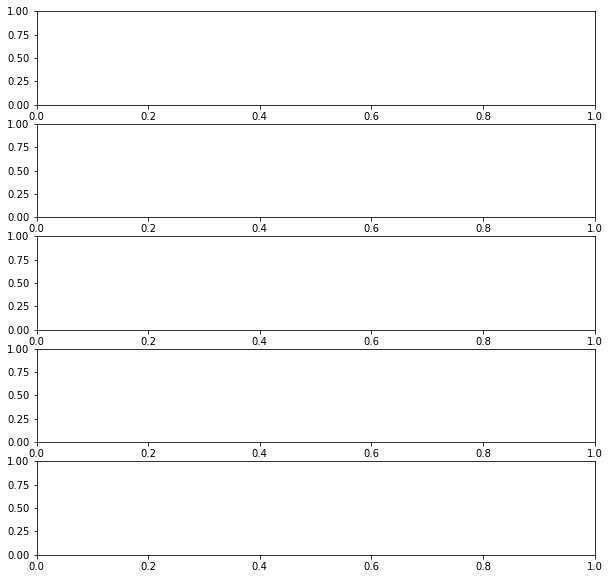

In [5]:
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(10,10))
color = "navy"

sns.lineplot(x = dfplot.Date, y = dfplot.Rainfall, ax = ax[0], color = color)
sns.lineplot(x = dfplot.Date, y = dfplot.Temperature, ax = ax[1], color = color)
sns.lineplot(x = dfplot.Date, y = dfplot.Drainage_Volume, ax = ax[2], color = color)
sns.lineplot(x = dfplot.Date, y = dfplot.River_Hydrometry, ax = ax[3], color = color)
sns.lineplot(x = dfplot.Date, y = dfplot.Depth_to_Groundwater, ax = ax[4], color = color)

for i in range(4):
    ax[i].set_xlim([date(2009, 1, 1), date(2019, 10, 1)])

plt.show()

In [6]:
df_downsampled["Temperature"].rolling(7).sum()

NameError: name 'df_downsampled' is not defined

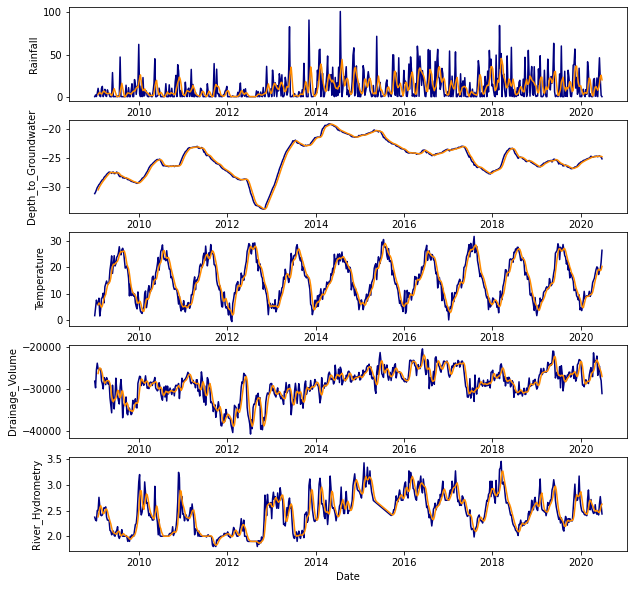

In [7]:
# Resample data on a weekly basis

def lplot(k, feature, color):
    return sns.lineplot(x = dfplot.Date, y = feature, ax = ax[k], color = color)

df_downsampled = df[['Date',
                "Depth_to_Groundwater",
                "Temperature",
                "Drainage_Volume",
                "River_Hydrometry"]].resample('7D', on = 'Date').mean().reset_index(drop=False)

df_downsampled["Rainfall"] = df[['Date', 'Rainfall']].resample('7D', on='Date').sum().reset_index(drop=False)[['Rainfall']]

dfplot = df_downsampled
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(10,10))
color = "navy"

for k, feature in enumerate(features):
    lplot(k, dfplot[feature], "navy")
    lplot(k, dfplot[feature].rolling(5, win_type='triang').mean(), "darkorange")

plt.show()

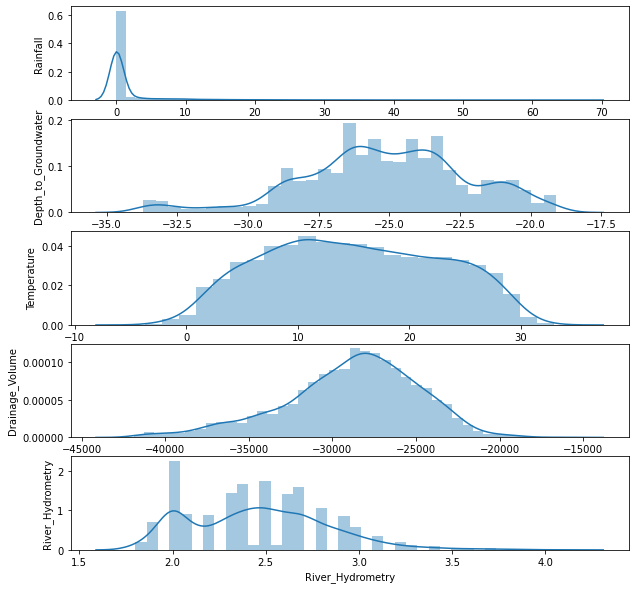

In [8]:
# Histograms
dfplot = df_downsampled
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(10,10))

for i, feature in enumerate(features):
    sns.distplot(df[feature], ax = ax[i])
    ax[i].set_ylabel(ylabel = feature)
    
plt.show()

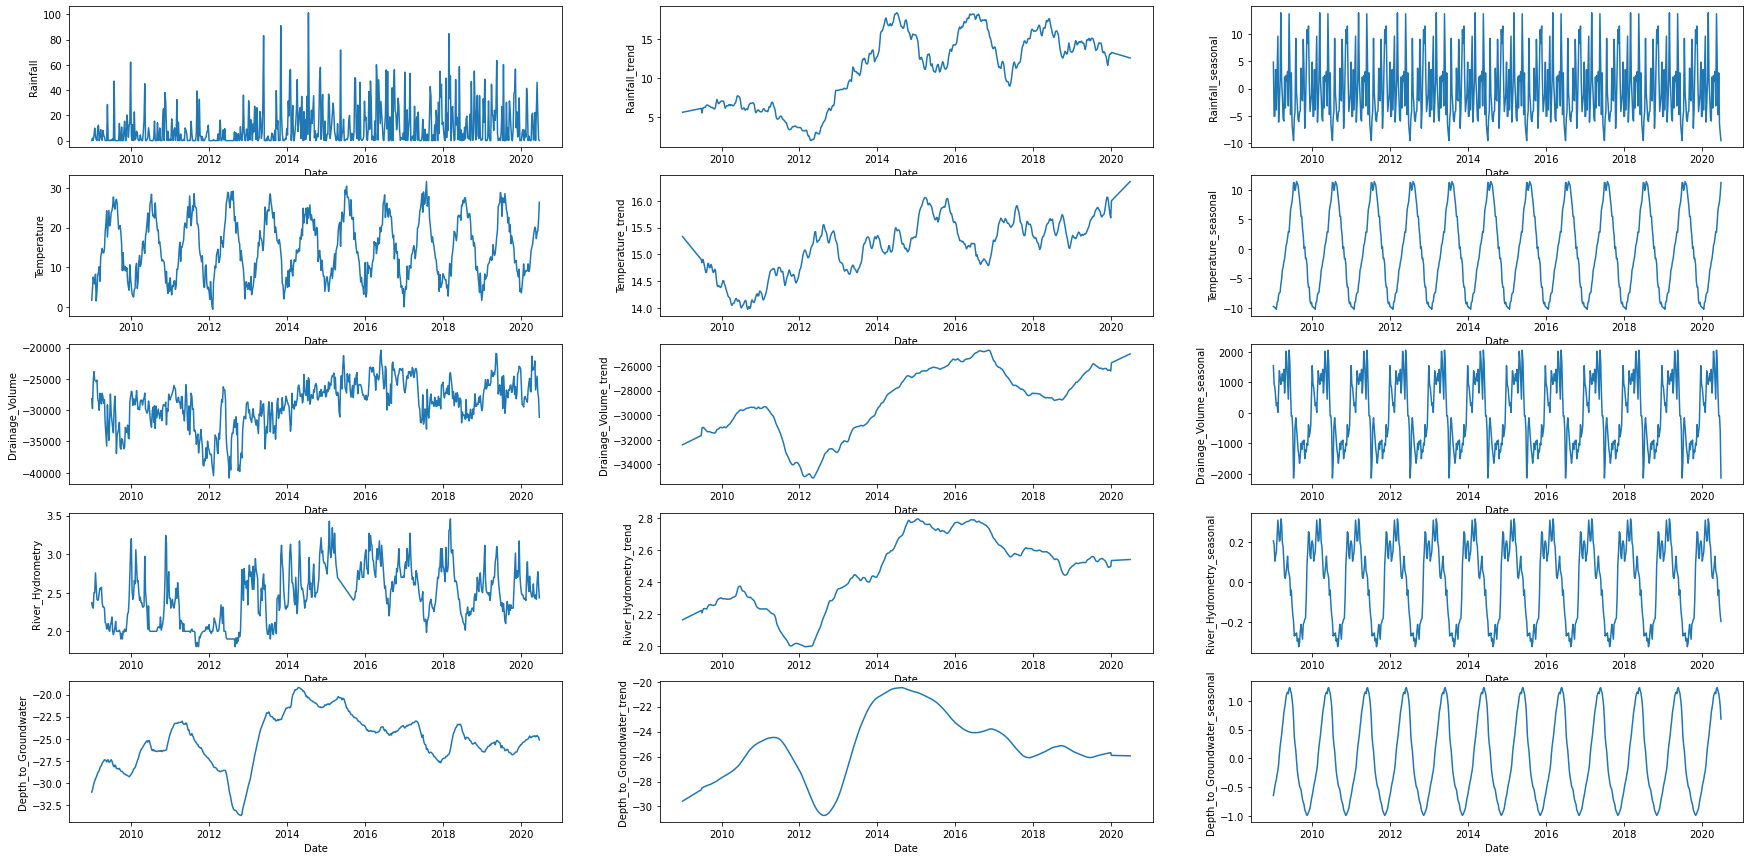

In [9]:
# Seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_cols = ["Rainfall", "Temperature", "Drainage_Volume", "River_Hydrometry", "Depth_to_Groundwater"]

dfplot["Depth_to_Groundwater"] = dfplot["Depth_to_Groundwater"].interpolate()

for col in decompose_cols:
    decomp = seasonal_decompose(dfplot[col], freq = 52, model = 'additive', extrapolate_trend = 'freq')
    dfplot[f"{col}_trend"] = decomp.trend
    dfplot[f"{col}_seasonal"] = decomp.seasonal

f, ax = plt.subplots(nrows=5, ncols=3, figsize=(30,15))

for k, col in enumerate(decompose_cols):
    sns.lineplot(x = dfplot.Date, y = dfplot[f"{col}"], ax = ax[k,0])
    sns.lineplot(x = dfplot.Date, y = dfplot[f"{col}_trend"], ax = ax[k,1])
    sns.lineplot(x = dfplot.Date, y = dfplot[f"{col}_seasonal"], ax = ax[k,2])
    
plt.show()

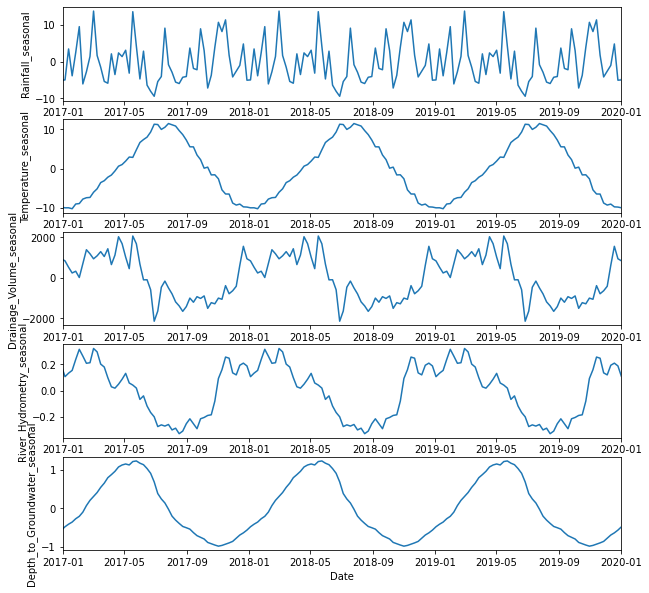

In [10]:
# Plot only seasonal components
f, ax = plt.subplots(nrows=5, ncols = 1, figsize = (10,10))

for k, col in enumerate(decompose_cols):
    sns.lineplot(x = dfplot.Date, y = dfplot[f"{col}_seasonal"], ax = ax[k])
    ax[k].set_xlim(([date(2017, 1, 1), date(2020, 1, 1)]))
plt.show()

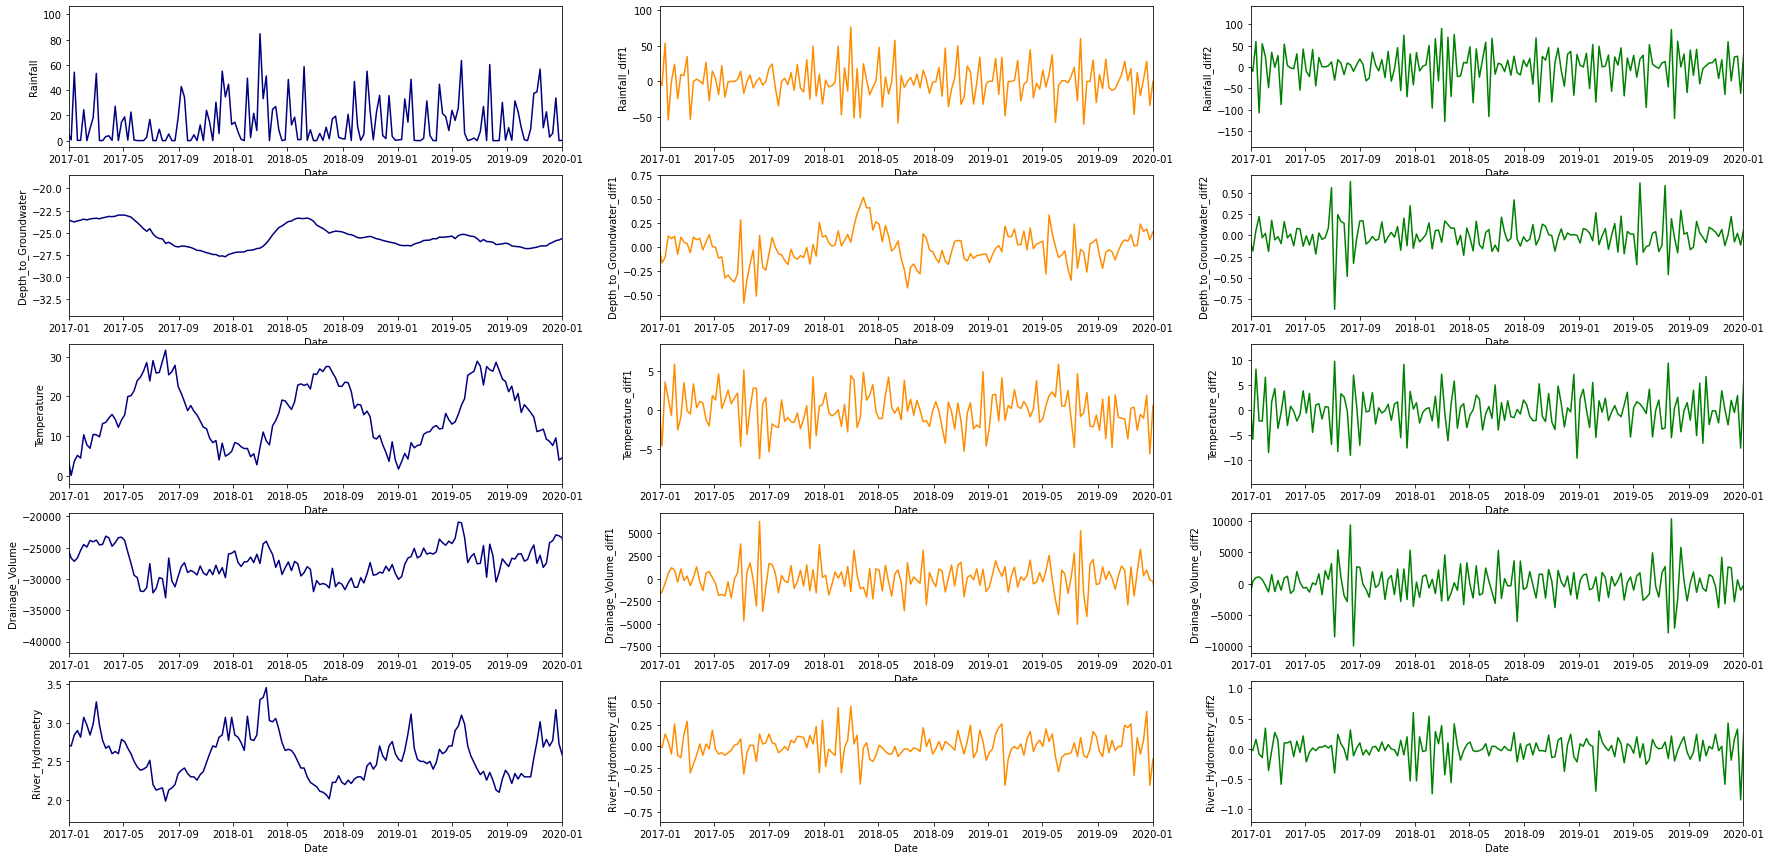

In [11]:
# Differencing
df = dfplot

for feature in features:
    
    # First order differencing
    ts_diff = np.diff(df[feature])
    df[f"{feature}_diff1"] = np.append([0], ts_diff)
    
    # Second order differencing
    ts_diff = np.diff(df[f"{feature}_diff1"])
    df[f"{feature}_diff2"] = np.append([0], ts_diff)
    
# Plot
f, ax = plt.subplots(nrows=5, ncols = 3, figsize = (30,15))
start = date(2017, 1, 1)
end = date(2020, 1, 1)


for k, feature in enumerate(features):
    sns.lineplot(x = df.Date, y = df[f"{feature}"], ax = ax[k, 0], color = "navy")
    sns.lineplot(x = df.Date, y = df[f"{feature}_diff1"], ax = ax[k, 1], color = "darkorange")
    sns.lineplot(x = df.Date, y = df[f"{feature}_diff2"], ax = ax[k, 2], color = "green")
    ax[k, 0].set_xlim(([start, end]))
    ax[k, 1].set_xlim(([start, end]))
    ax[k, 2].set_xlim(([start, end]))

# Original, first order differenced and second order differenced

## ACF and PACF
- Autocorrelation is the correlation between variable at t and at t minus lag
- e.g. if high at low lag and low at high lag, means highly depend on recent numbers, and less dependent as time goes on
- Partial autocorrelation is local - only shows the correlation of a variable to the previous one
- e.g. if low, variable does not depend on its recent state, if high, depends on recent state more
- So ACF is a long term and PACF a short term autocorrelation 
https://people.duke.edu/~rnau/411arim3.htm

The number of significant (beyond the 95% confidence interval shown by blue bar) spikes in the PACF tells you how many AR terms in ARIMA you need to explain the autocorrelation pattern.

In the data, the rainfall seems autocorrelated for about 12 weeks (3 months, or a season).
    

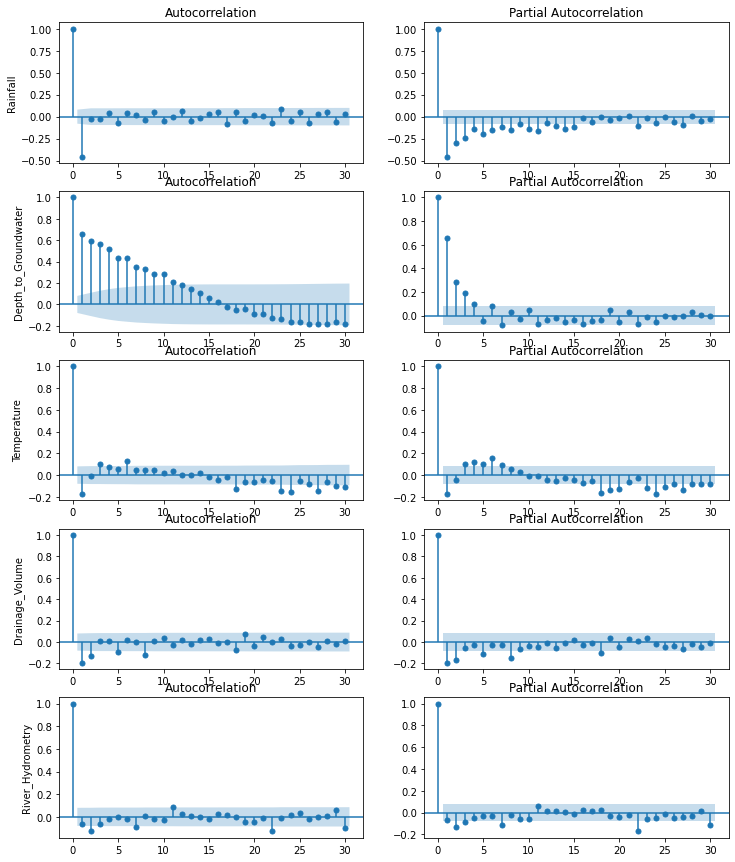

In [13]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=5, ncols = 2, figsize = (12,15))

for k, feature in enumerate(features):
    #autocorrelation_plot(df[f"{feature}_diff1"], ax = ax[k,0])
    plot_acf(df[f"{feature}_diff1"], ax = ax[k,0], lags = 30)
    plot_pacf(df[f"{feature}_diff1"], ax = ax[k,1], lags = 30)
    ax[k,0].set_ylabel(feature)
    
plt.show()

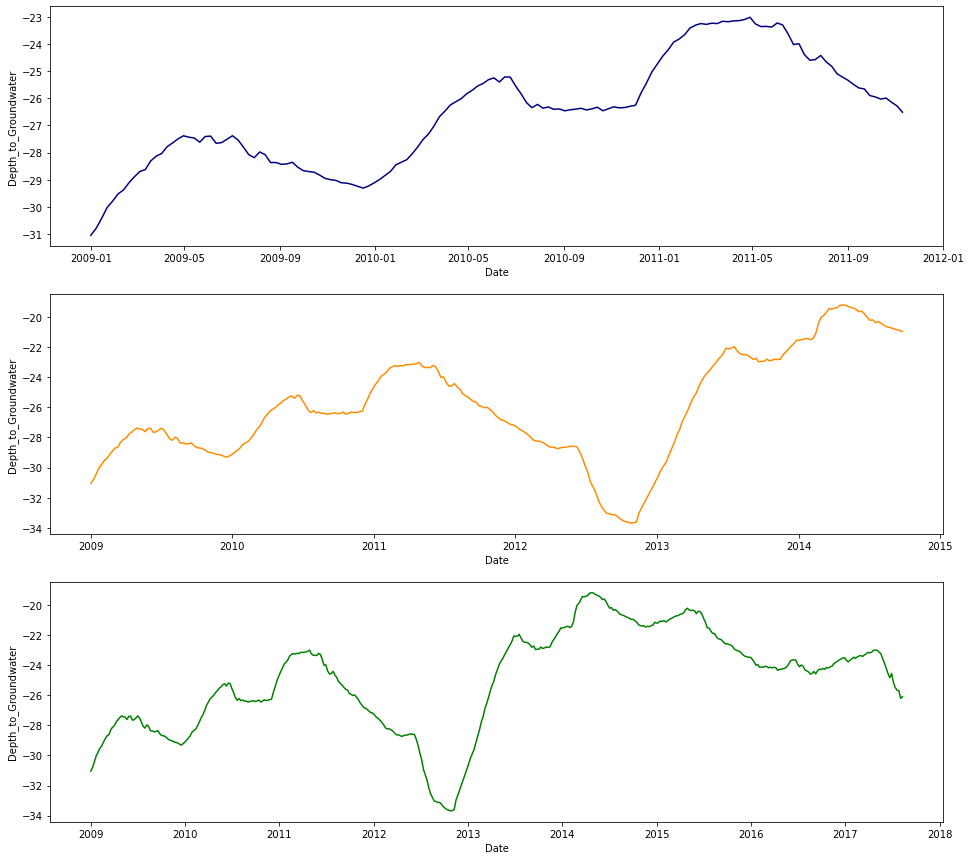

In [27]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit

n_splits = 3

folds = TimeSeriesSplit(n_splits = n_splits)

x = df.Date
y = df.Depth_to_Groundwater

colors = ["navy", "darkorange", "green"]

f, ax = plt.subplots(nrows=3, ncols = 1, figsize=(16,15))
for i, (train_index, valid_index) in enumerate(folds.split(x)):

    x_train, x_valid = x[train_index], x[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]
    
    sns.lineplot(x = x_train, y = y_train, color = colors[i], ax = ax[i])
    
    
plt.show()
